## To do list:

* Figure out how to run standardized model on original dataset
* Shale Hills pits are converted to nan, which seems to be due to the fact that there is no soil moisture or Bulk EC data. We may need to run another model without soil moisture and bulk EC if we want to include Shale Hills.
* Should we include site and pit in the PCA?
* Add a column for season
* Add a date column?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 1, 
            'Catalina-Jemez': 2, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [5]:
print(np.unique(df['Depth'].values))

[  2.  10.  20.  30.  50.  60.  70.  80. 100. 140. 150.]


In [4]:
outfile = '../../merged_processed_data/MergeProcessedData.csv'
np.savetxt(outfile, merged, fmt='%.4f', delimiter=",")


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
df.drop(columns=['WaterPotential', 'ReductionPotential', 'Pit', 'timestamp'], 
        inplace=True)

df=df.dropna()
df

,CO2,precip,SoilMoisture,BulkEC,Temp,O2,Depth,Site
129166,1453.41075,0.00,0.055333,0.000000,7.68475,21.36250,10.0,2.0
129167,1476.43275,0.85,0.052750,0.000000,7.94825,21.32250,10.0,2.0
129168,1489.56425,0.85,0.066250,0.000000,8.19700,21.30325,10.0,2.0
129169,1506.36675,0.85,0.075000,0.005000,8.34700,21.29675,10.0,2.0
129170,1510.89750,0.85,0.075000,0.000000,8.24200,21.30625,10.0,2.0
...,...,...,...,...,...,...,...,...
1393070,625.05675,0.00,0.098000,0.008333,0.70850,13.77800,10.0,2.0
1393071,620.41800,0.00,0.098000,0.010000,0.68825,13.77775,10.0,2.0
1393072,611.34600,0.00,0.098000,0.010000,0.63875,13.78050,10.0,2.0
1393073,607.84425,0.00,0.098000,0.010000,0.60550,13.77400,10.0,2.0


In [50]:
df['new_index']=list(range(0, 758303))
df_reindex=df.set_index('new_index')
df=df.drop(columns='new_index')
#df_reindex=df_reindex.drop(columns='Site')

df_st =  StandardScaler().fit_transform(df_reindex) 
df_st1=pd.DataFrame(data=df_st)
#df_med=df_st1.fillna(df_st1.median())
df_st1

,0,1,2,3,4,5,6,7
0,2.303436,-0.372144,1.905608,0.116558,1.420834,0.841439,0.401412,-5.223239
1,2.369751,-0.372144,1.905608,0.116558,1.432677,0.842562,0.401412,-5.223239
2,2.438617,-0.372144,1.905608,0.116558,1.444520,0.843685,0.401412,-5.223239
3,2.493455,-0.372144,1.905608,0.116558,1.454542,0.844635,0.401412,-5.223239
4,2.544466,-0.372144,1.905608,0.116558,1.463652,0.845499,0.401412,-5.223239
...,...,...,...,...,...,...,...,...
758298,3.250688,-0.372144,0.129595,1.805887,0.937570,-1.008125,0.779653,0.191452
758299,3.218468,-0.372144,0.121805,1.768010,0.938467,-1.020290,0.779653,0.191452
758300,3.190756,-0.372144,0.123753,1.730133,0.934684,-1.041677,0.779653,0.191452
758301,3.164809,-0.372144,0.075847,1.768010,0.930865,-1.075321,0.779653,0.191452


In [22]:
#df_st1=pd.DataFrame(data=df_st)
#df_med = df_st1.fillna(df_st1.median())
#pca = PCA(.95)
#pca.fit(X_train)
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

In [51]:
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
df_st_transform
df_st=df_st[df_st_transform[:,0]<=12]
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
len(df_st[:,0])

758297

In [52]:
#pca_scores = PCA().fit_transform(df_st)

#df_st
#df_pca=pd.DataFrame(data=pca_scores)
#df_pca.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth']
pca.explained_variance_ratio_


array([0.24093615, 0.23832208, 0.12740493, 0.12211238, 0.09096434,
       0.07280505, 0.06556726])

In [53]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_reindex.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
CO2,0.388168,0.415578,-0.061862,0.040278,0.244816,-0.539041,0.565421
Precip,0.163424,0.057024,0.511381,0.820494,-0.169290,0.062218,-0.026506
SoilMoisture,0.568953,-0.178407,0.092309,-0.201695,-0.403866,-0.138653,-0.157980
BulkEC,0.439761,-0.264886,-0.225326,0.078613,0.225349,0.678150,0.410508
Temp,0.116824,0.543928,0.116972,-0.035220,0.555283,0.265977,-0.433360
O2,-0.442751,0.398170,-0.047713,0.037393,-0.354526,0.280021,0.450581
Depth,0.124447,0.221071,-0.792031,0.395061,-0.238998,-0.042243,-0.302045
Site,-0.283477,-0.467740,-0.179158,0.345824,0.454278,-0.274793,0.063773


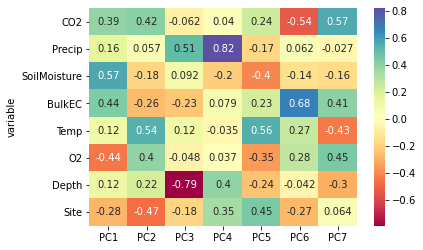

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

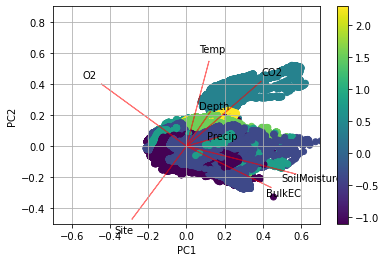

In [55]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = df_st[:,6])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns.values[i], color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [30]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [31]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [ ]:
#Run this for machine learning model with standardization

from sklearn.model_selection import train_test_split

df_st1.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth', 'Site']
X=df_st1[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth']]  # Features\n",
y=df_st1['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [56]:
#Run this for machine learning model without standardization

from sklearn.model_selection import train_test_split

df.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Depth', 'Site']
X=df[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2',  'Depth', 'Site']]  # Features\n",
y=df['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.9444715107496087

In [14]:
len(X_train)


606642

In [59]:
#X_original=df.iloc[y_train]
prediction=neigh.predict(X_test)
df_pred=pd.DataFrame(data=prediction)
#prediction_original_dataset=neigh.predict(X_original)


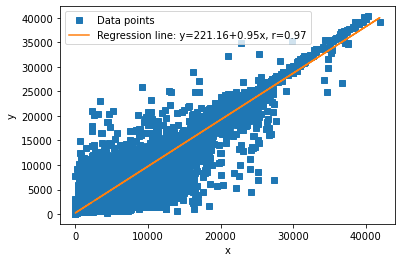

In [60]:
import scipy.stats
x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [44]:
result = scipy.stats.linregress(y_test, prediction)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(y_test, prediction))
print(metrics.max_error(y_test, prediction))
print(metrics.mean_absolute_error(y_test, prediction))
print(metrics.mean_squared_error(y_test, prediction, squared=False))




0.9757646486645984
0.0
0.9645638678783376
0.0005554488613623844
0.9519504588515034
23362.8185
299.3208254090264
860.7146186332759


In [19]:
r, p = scipy.stats.pearsonr(y_test, prediction)
print (r)
print (p)

0.9854652153505192
0.0


In [20]:
result = scipy.stats.spearmanr(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9750862939654055
0.0


In [21]:

result = scipy.stats.kendalltau(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9137826224527774
0.0


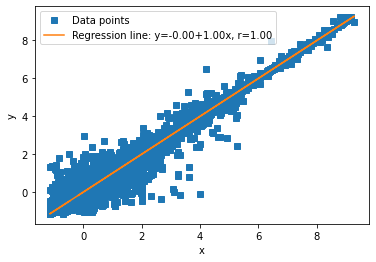

In [117]:
#Standardized model performs slightly better, but I can't figure out how to test the standardized model on different depths or pits. 
#I also can't figure out how to inverse transform the standardized values to get predictions for the the original dataframe, so I am just using the unstandardized model

x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [62]:
y_hats=prediction
df_out = X_test.reset_index()
df_out["Actual"] = y_test.reset_index()['CO2']
df_out["Prediction"] = y_hats#.reset_index()[0]
y_test['preds'] = y_hats
df_out
#df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)

,index,Precip,Soil Moisture,Bulk EC,Temp,O2,Depth,Site,Actual,Prediction
0,958444,0.00,0.047000,0.000000,12.32375,19.318750,60.0,3.0,2761.08075,3176.700650
1,895270,0.00,0.094000,0.027500,14.02300,19.290750,10.0,3.0,5038.79750,2118.480237
2,32850,0.54,0.328000,0.050000,26.95500,19.156969,50.0,1.0,5950.00000,5914.000000
3,1740976,0.00,0.189000,0.140000,9.01100,13.278250,30.0,3.0,3571.67475,3390.881700
4,951254,0.00,0.050500,0.000000,13.62500,19.291000,60.0,3.0,4052.71575,4027.781650
...,...,...,...,...,...,...,...,...,...,...
151656,2532629,3.52,0.206000,0.133333,9.96075,13.470750,10.0,3.0,1819.37450,3043.621350
151657,766064,2.04,0.127000,0.027500,2.00200,19.485750,10.0,3.0,2819.56375,2822.382700
151658,682970,0.00,0.086250,0.017500,11.38850,18.799750,60.0,3.0,2722.08175,2956.736400
151659,1809655,3.44,0.390167,0.070000,4.91550,9.218500,60.0,3.0,559.22650,566.890900


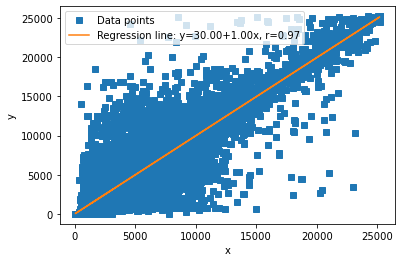

In [74]:
#For some reason the Shale Hills data has been dropped
#All pits show high level of prediction accuracy (pit 20 is probably lowest accuracy)

df_out=df_out.astype('float32')
x=df_out.Prediction[df_out.Site==3]
y=df_out.Actual[df_out.Site==3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [86]:
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.stderr)
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))
np.any(df_out.Depth==2)

0.9659167119983264
0.0
0.0006972487470096001
0.9288502621814316
19582.793
370.03955
891.9108


False

In [66]:
x=df_out.Prediction[df_out.Depth==2]
y=df_out.Actual[df_out.Depth==2]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

ValueError: Inputs must not be empty.

In [31]:
import scipy.stats
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))


0.9468114299326165
0.0
0.9740731890348098
0.0018740755955364203
0.8896377205078887
11663.627
278.59265
761.34607


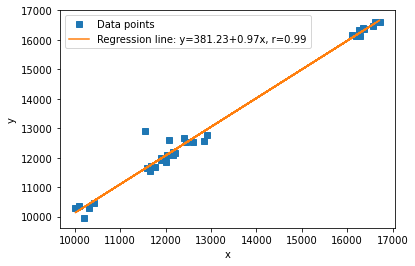

In [32]:
x=df_out.Prediction[df_out.Temp>=31.5]
y=df_out.Actual[df_out.Temp>=31.5]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

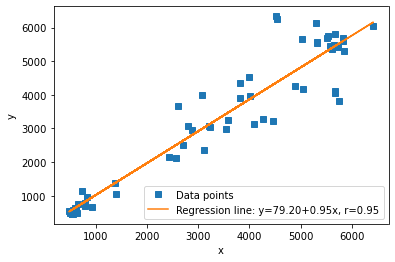

In [33]:
x=df_out.Prediction[df_out.Temp<=-3]
y=df_out.Actual[df_out.Temp<=-3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()